In [1]:
from src.bounds import *
import torch
from dataclasses import dataclass
import numpy as np
from src.utils import predict
from src.metric import balanced_accuracy
import matplotlib.pyplot as plt

In [2]:
save_root = "../data/rxrx1/"
Z = torch.load(save_root+"rxrx_val_logits.pt")
X = torch.softmax(Z, -1)
y = torch.load(save_root+"rxrx_val_labels.pt").int()

In [3]:
Z.shape, X.shape, y.shape

(torch.Size([9854, 1139]), torch.Size([9854, 1139]), torch.Size([9854]))

In [4]:
@dataclass
class Split:
    X: torch.Tensor

In [5]:
n_val = 1000
delta = 0.05
num_hypotheses = 200
correction = delta/(num_hypotheses)

In [6]:
L_BJ = berk_jones_two_sided(n_val, correction, 0.0, 1.0)

In [7]:
thresholds = torch.logspace(-10, 0, num_hypotheses)
thresholds[0] = 0.0

In [8]:
preds = torch.gt(X.unsqueeze(-1), thresholds).int()

In [9]:
y_one_hot = torch.zeros((y.shape[0], 1139)).int()
for i in range(y.shape[0]):
    y_one_hot[i, y[i]]=1
y_one_hot.shape, preds.permute(0,2,1).shape

(torch.Size([9854, 1139]), torch.Size([9854, 200, 1139]))

In [10]:
loss = 1 - balanced_accuracy(preds.permute(0,2,1), y_one_hot.unsqueeze(1))

In [11]:
loss.shape

torch.Size([9854, 200])

In [12]:
p = torch.randperm(loss.size()[0])
loss = loss[p,:]

In [13]:
train_split = Split(
    X=loss[:n_val],
)

test_split = Split(
    X=loss[n_val:],
)

In [14]:
del loss, preds, y_one_hot

In [15]:
full_aucs = integrate_quantiles(train_split.X.T, L_BJ)

In [16]:
## Q1: how to calculate gini coefficient
## Q2: how to calculate CDF upper bound

In [17]:
def calc_gini(X, L, U, beta_min=0.0, beta_max=1.0):

    mean_U = integrate_quantiles(X, U)
    print(mean_U)

    b = L
    dist_max = 1.0
    X_sorted = np.sort(X, axis=-1)
    b_lower = np.concatenate([np.zeros(1), b], -1)
    b_upper = np.concatenate([b, np.ones(1)], -1)
    
    # clip bounds to [beta_min, 1]
    b_lower = np.maximum(b_lower, beta_min)
    b_upper = np.maximum(b_upper, b_lower)
    
    # clip bounds to [0, beta_max]
    b_upper = np.minimum(b_upper, beta_max)
    b_lower = np.minimum(b_upper, b_lower)

    heights = b_upper - b_lower
    widths = np.concatenate([X_sorted, np.full((X_sorted.shape[0], 1), dist_max)], -1)

    res = np.cumsum(heights * widths, -1)/np.expand_dims(mean_U, -1)
    res *= heights
    res = 1 - np.sum(res, -1)
    return res
    
U_BJ = np.clip(L_BJ+0.2, 0, 1)

group_diff = calc_gini(train_split.X.T, L_BJ, U_BJ)

[0.5        0.31588473 0.31378776 0.31182375 0.30959331 0.30755904
 0.30544418 0.30320749 0.30081298 0.29852175 0.29617006 0.29383129
 0.29136181 0.28904302 0.28681823 0.28437684 0.28175236 0.27934899
 0.27661573 0.27428103 0.27181694 0.2694868  0.2668775  0.26459702
 0.26204836 0.25932084 0.25689489 0.25413765 0.25132937 0.24847026
 0.24567548 0.24293406 0.24029371 0.23732813 0.23482256 0.23205357
 0.22929355 0.22653356 0.22374981 0.22110964 0.21808058 0.21551473
 0.21270286 0.20967958 0.20665505 0.20380439 0.2008317  0.19818376
 0.19503579 0.19254474 0.18983652 0.18670002 0.18429093 0.18137437
 0.1787386  0.17584905 0.17271864 0.16986395 0.16758299 0.1651485
 0.16202237 0.16000354 0.15722349 0.15503187 0.1521878  0.14907915
 0.14601285 0.14296212 0.1403577  0.13739737 0.13457677 0.13296213
 0.13025956 0.1275318  0.12515245 0.12245588 0.12026644 0.11771874
 0.11606745 0.1133171  0.11153075 0.10948849 0.10721972 0.10480266
 0.10305993 0.10121635 0.10091746 0.10064765 0.09978068 0.10000

In [18]:
max(group_diff)

0.5723715944334234

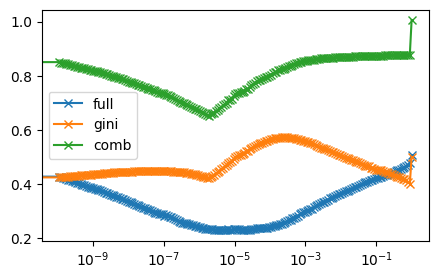

In [19]:
plt.rcParams["figure.figsize"] = (5,3)

plt.plot(thresholds, full_aucs, "-x", label="full")
plt.plot(thresholds, group_diff, "-x", label="gini")
plt.plot(thresholds, full_aucs+group_diff, "-x", label="comb")
plt.xscale("log")
plt.legend()
plt.show()

In [20]:
total_loss = full_aucs+group_diff

best_ind = np.argmin(total_loss)
best_guar = total_loss[best_ind]
best_ind, best_guar

(85, 0.6526833012266017)

In [21]:
full_aucs[best_ind], group_diff[best_ind]

(0.23150347359791457, 0.4211798276286871)

In [22]:
test_loss = np.expand_dims(test_split.X[:, best_ind], -1)
print(test_loss.shape)
test_mean = np.mean(test_loss)
test_mean

(8854, 1)


0.18948095

In [23]:
int_x = np.arange(1, test_split.X.shape[0] + 1) / test_split.X.shape[0]
test_gini_loss = calc_gini(test_split.X.T, int_x, int_x)[best_ind]
test_gini_loss

[0.5        0.39731558 0.39528975 0.39315762 0.39106033 0.38888051
 0.38662969 0.3844728  0.38216525 0.3800423  0.37777654 0.3757511
 0.37363486 0.37130815 0.3687642  0.36641418 0.36420449 0.3616716
 0.35902378 0.35653501 0.35407517 0.35138622 0.34877745 0.34614596
 0.34341473 0.34058887 0.33785585 0.33492493 0.33228917 0.32928143
 0.32640346 0.32348798 0.32053974 0.31774221 0.31506026 0.31270874
 0.30956658 0.30675614 0.30359413 0.30050238 0.29772068 0.29424678
 0.29137342 0.28830837 0.28541303 0.28237215 0.27912905 0.27610658
 0.27344467 0.27021442 0.26732831 0.26423666 0.26190455 0.25885647
 0.25600639 0.25327645 0.2507252  0.24802285 0.24567327 0.24332935
 0.24086856 0.23849675 0.23583127 0.23314123 0.23017106 0.2282148
 0.22534288 0.22274628 0.22061717 0.21839662 0.21586284 0.21364382
 0.21149015 0.20894094 0.20712685 0.20514176 0.20303464 0.20149869
 0.19993977 0.19846838 0.19661454 0.19521793 0.19364035 0.19173034
 0.19079111 0.18948095 0.18802613 0.18705684 0.18579615 0.1853181

0.7487669149664891

In [24]:
total_test_loss = test_mean + test_gini_loss
total_test_loss

0.938247860434438

We choose a classification threshold that minimizes an upper bound on:
$$
E[L(X)]+ Gini(X)
$$
for balanced accuracy loss.

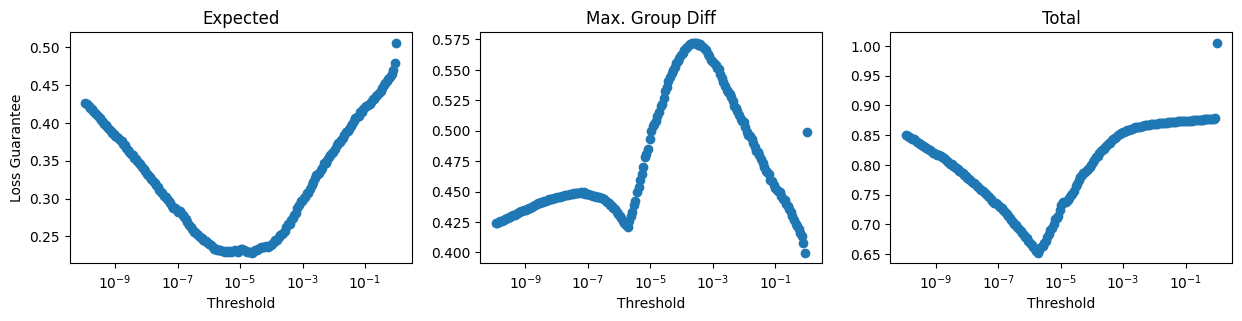

In [25]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1,3) 

ax[0].scatter(thresholds, full_aucs)
ax[0].set_xlabel("Threshold")
ax[0].set_ylabel("Loss Guarantee")
ax[0].set_title("Expected")
ax[0].set_xscale("log")

ax[1].scatter(thresholds, group_diff)
ax[1].set_xlabel("Threshold")
ax[1].set_title("Max. Group Diff")
ax[1].set_xscale("log")

ax[2].scatter(thresholds, total_loss)
ax[2].set_xlabel("Threshold")
ax[2].set_title("Total")
ax[2].set_xscale("log")

plt.show()

In [26]:
print("Guarantee:", best_guar, "| Actual:", total_test_loss)
print("Gini Guarantee:", group_diff[best_ind], "| Actual:", test_gini_loss)
print("Mean Guarantee:", full_aucs[best_ind], "| Actual:", test_mean)

Guarantee: 0.6526833012266017 | Actual: 0.938247860434438
Gini Guarantee: 0.4211798276286871 | Actual: 0.7487669149664891
Mean Guarantee: 0.23150347359791457 | Actual: 0.18948095
